In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
log_list = ['../checkpoints/2023-09-04_GM-ResNet-5state/logs/logs.pkl',
            '../checkpoints/2023-09-04_GM-UNet-5state/logs/logs.pkl',
            '../checkpoints/2023-09-05_GM-FNO-5state/logs/logs.pkl']
logs = []
for l in log_list:
    f = open(l, 'rb')
    logs.append(pickle.load(f))
    # train_log.keys()
    # print(np.array(train_log['train_metrics']).shape)


In [12]:
def plot_train(log_list, name):
    fig, ax = plt.subplots()
    labels = ['ResNet', 'UNet', 'FNO']
    color_cycle = ax._get_lines.prop_cycler
    if 'Loss' in name: 
        for i, log in enumerate(log_list):
            color = next(color_cycle)['color']
            ax.plot(log['train_loss'], color=color, label=f'{labels[i]} Train')
            ax.plot(log['val_loss'], '--', color=color, label=f'{labels[i]} Val')
    else:
        ax.plot(log['train_metrics'], label='Train')
        ax.plot(log['val_metrics'], label='Val')
    ax.set_box_aspect(1/1.62)
    # ax.grid()
    ax.set_ylim(0,.5)
    ax.legend()
    ax.set_title(name)
    return fig

def plot_metrics(log):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    names = [r"$R^2$", "sMAPE", "rel-MSE"]
    tmetrics = np.array(log['train_metrics'])
    vmetrics = np.array(log['val_metrics'])
    for i, a in enumerate(ax):
        a.plot(tmetrics[:,i], label='Train')
        a.plot(vmetrics[:, i], label='Val')
        a.set_title(names[i])
        a.grid()
        a.set_box_aspect(1/1.61)
        a.legend()
    return fig

def plot_field(data):
    # data: 2D array
    fig, ax = plt.subplots()
    im=ax.imshow(data, cmap='seismic', aspect='auto', origin='lower')
    fig.colorbar(im)
    return fig

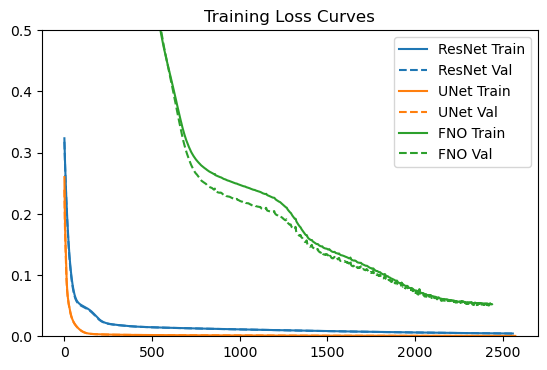

In [14]:
loss_plot = plot_train(logs, 'Training Loss Curves')
loss_plot.savefig('../eval_plots/train_curves.png', dpi=300, bbox_inches='tight')
plt.show()

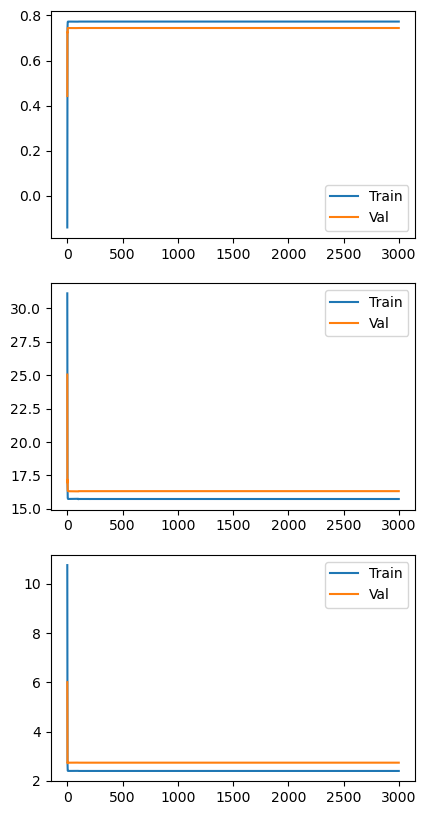

In [51]:
metric = plot_metrics(train_log)

In [22]:
import h5py
f = h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/varyGM/PCA_data.h5', 'r')
data = f['PCA_data'][:]

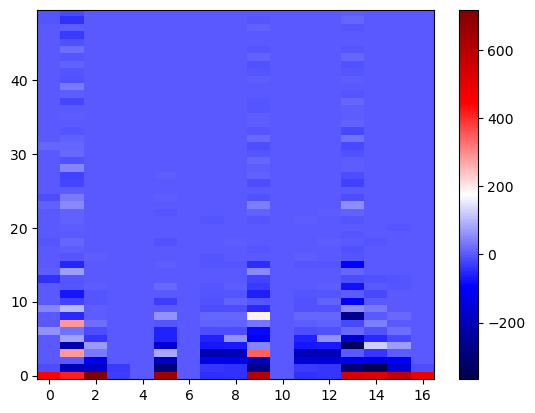

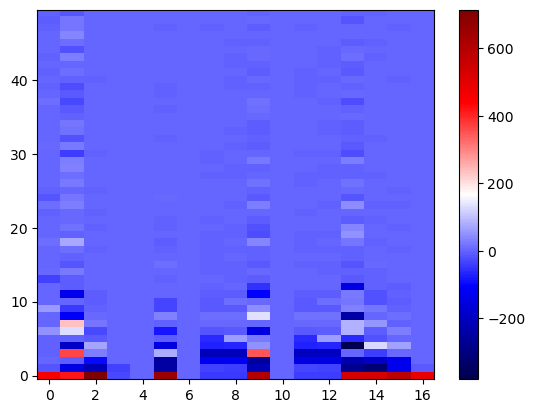

In [35]:
random_num = np.random.randint(data.shape[0])
field = plot_field(data[10])
field2 = plot_field(data[11])

In [14]:
# Making rollout animation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
from glob import glob
import os
import re
# Load the PNG images

image_files = sorted(glob('../eval_plots/rollout/Unet/01/temperature/*'), key=lambda x:float(re.findall("(t\d+)",x)[0][1:]))


# images = [imageio.imread(img_file) for img_file in image_files]

# import imageio

# # List of PNG image paths



images = [imageio.imread(image_file) for image_file in image_files]

output_file = 'Unet-temp-rollout.gif'
imageio.mimsave(output_file, images, duration=1)  # `duration` is the time for each frame in seconds



/tmp/ipykernel_1362711/3578840570.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(image_file) for image_file in image_files]
